# Model Development and Evaluation



In [4]:
#Import libraries

!pip install imbalanced-learn
!pip install tensorflow

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler


## 1. Data Processing

In [5]:
#read the data file with pandas

df = pd.read_csv('../data/healthcare-dataset-stroke-data.csv')
df.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
#format the data
df = df.drop(columns=['id'])
df = df.rename(columns=str.lower)
df = df[df.gender != 'Other']



In [7]:
#Handle missing values of BMI

# Impute missing 'bmi' values with the median for each stroke group
df['bmi'] = df.groupby('stroke')['bmi'].transform(lambda x: x.fillna(x.median()))

# Check for missing values again to confirm imputation
print("Missing values after imputation:")
print(df.isnull().sum())

Missing values after imputation:
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [8]:
df2=df.copy()

## 2. Feature Engineering

In [9]:
# Create age groups
def categorize_age(age):
    if age < 18:
        return 'Child'
    elif age < 35:
        return 'Young Adult'
    elif age < 55:
        return 'Middle-aged'
    elif age < 75:
        return 'Senior'
    else:
        return 'Elderly'

df['age_group'] = df['age'].apply(categorize_age)

# BMI Binning
df['bmi_category'] = pd.cut(
    df['bmi'],
    bins=[0, 18.5, 24.9, 29.9, df['bmi'].max()],
    labels=['Underweight', 'Normal', 'Overweight', 'Obese'],
    right=False
)

df.head()


,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group,bmi_category
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,Senior,Obese
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,29.7,never smoked,1,Senior,Overweight
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,Elderly,Obese
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,Middle-aged,Obese
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,Elderly,Normal


## 3. Prediction model of Stroke

3.1 Use age_group and bmi_group for prediction

In [10]:
df = df.drop(columns=['age', 'bmi'])

In [11]:
#recoding categorical data

df = pd.get_dummies(df, columns=['age_group', 'gender', 'ever_married', 'work_type', 'residence_type', 'smoking_status', 'bmi_category'])


In [12]:
# Separate features and target
X = df.drop('stroke', axis=1)
y = df['stroke']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)


In [13]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("After SMOTE:")
print(y_train_res.value_counts())

After SMOTE:
stroke
0    3888
1    3888
Name: count, dtype: int64


In [14]:
df.head()

,hypertension,heart_disease,avg_glucose_level,stroke,age_group_Child,age_group_Elderly,age_group_Middle-aged,age_group_Senior,age_group_Young Adult,gender_Female,...,residence_type_Rural,residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,bmi_category_Underweight,bmi_category_Normal,bmi_category_Overweight,bmi_category_Obese
0,0,1,228.69,1,False,False,False,True,False,False,...,False,True,False,True,False,False,False,False,False,True
1,0,0,202.21,1,False,False,False,True,False,True,...,True,False,False,False,True,False,False,False,True,False
2,0,1,105.92,1,False,True,False,False,False,False,...,True,False,False,False,True,False,False,False,False,True
3,0,0,171.23,1,False,False,True,False,False,True,...,False,True,False,False,False,True,False,False,False,True
4,1,0,174.12,1,False,True,False,False,False,True,...,True,False,False,False,True,False,False,True,False,False


Class Weights: {0: 1.0, 1: 5.0}
Random Forest Results:
AUC: 0.7357, F1: 0.0615, Accuracy: 0.9403, Precision: 0.1333, Recall: 0.0400


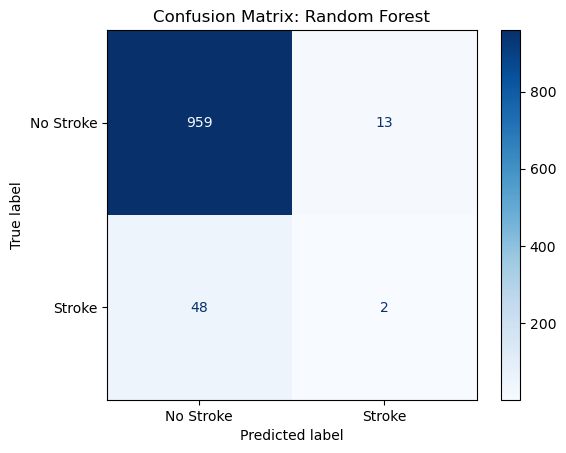


Logistic Regression Results:
AUC: 0.8456, F1: 0.3222, Accuracy: 0.8806, Precision: 0.2231, Recall: 0.5800


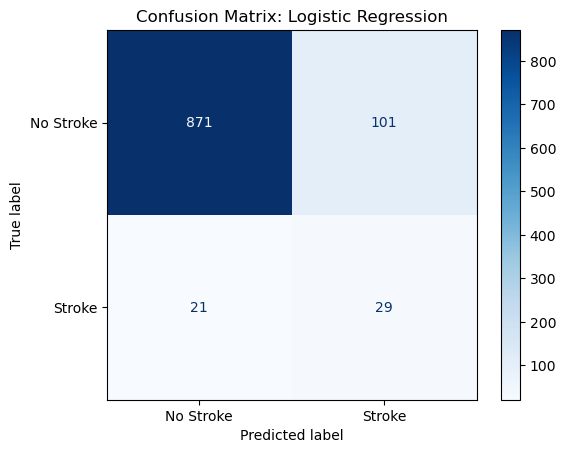


Decision Tree Results:
AUC: 0.5584, F1: 0.1600, Accuracy: 0.9178, Precision: 0.1600, Recall: 0.1600


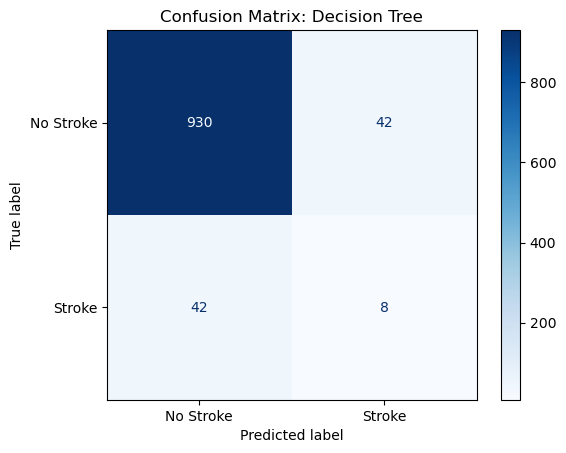

32/32 [==============================] - 0s 1ms/step

Deep Learning Results:
AUC: 0.7639, F1: 0.1346, Accuracy: 0.9119, Precision: 0.1296, Recall: 0.1400


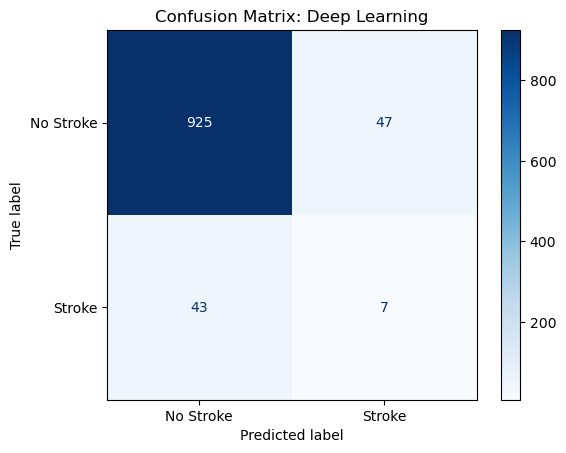


Model Performance Summary:


,Model,AUC,F1,Accuracy,Precision,Recall
0,Random Forest,0.735720,0.061538,0.940313,0.133333,0.04
1,Logistic Regression,0.845597,0.322222,0.880626,0.223077,0.58
2,Decision Tree,0.558395,0.160000,0.917808,0.160000,0.16
3,Deep Learning,0.763930,0.134615,0.911937,0.129630,0.14


In [25]:
results_df = pd.DataFrame(columns=['Model', 'AUC', 'F1', 'Accuracy', 'Precision', 'Recall'])

#Define class weights for imbalanced classes
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(class_weight={0: 1, 1: 5}, classes=np.unique(y_train_res), y=y_train_res)
class_w = dict(zip(np.unique(y_train_res), weights))
print("Class Weights:", class_w)


# Train and Evaluate Random Forest
rf_model = RandomForestClassifier(random_state=42, class_weight=class_w)
rf_model.fit(X_train_res, y_train_res)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
y_pred_rf = rf_model.predict(X_test)

auc_rf = roc_auc_score(y_test, y_proba_rf)
f1_rf = f1_score(y_test, y_pred_rf, zero_division=0)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, zero_division=0)
recall_rf = recall_score(y_test, y_pred_rf, zero_division=0)

results_df.loc[len(results_df)] = ['Random Forest', auc_rf, f1_rf, accuracy_rf, precision_rf, recall_rf]

print("Random Forest Results:")
print(f"AUC: {auc_rf:.4f}, F1: {f1_rf:.4f}, Accuracy: {accuracy_rf:.4f}, Precision: {precision_rf:.4f}, Recall: {recall_rf:.4f}")

cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["No Stroke", "Stroke"])
disp_rf.plot(cmap="Blues")
plt.title("Confusion Matrix: Random Forest")
plt.show()

# Train and Evaluate Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight=class_w)
lr_model.fit(X_train_res, y_train_res)
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]
y_pred_lr = lr_model.predict(X_test)

auc_lr = roc_auc_score(y_test, y_proba_lr)
f1_lr = f1_score(y_test, y_pred_lr, zero_division=0)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, zero_division=0)
recall_lr = recall_score(y_test, y_pred_lr, zero_division=0)

results_df.loc[len(results_df)] = ['Logistic Regression', auc_lr, f1_lr, accuracy_lr, precision_lr, recall_lr]

print("\nLogistic Regression Results:")
print(f"AUC: {auc_lr:.4f}, F1: {f1_lr:.4f}, Accuracy: {accuracy_lr:.4f}, Precision: {precision_lr:.4f}, Recall: {recall_lr:.4f}")

cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["No Stroke", "Stroke"])
disp_lr.plot(cmap="Blues")
plt.title("Confusion Matrix: Logistic Regression")
plt.show()


# Train and Evaluate Decision Tree
dt_model = DecisionTreeClassifier(random_state=42, class_weight=class_w)
dt_model.fit(X_train_res, y_train_res)
y_proba_dt = dt_model.predict_proba(X_test)[:, 1]
y_pred_dt = dt_model.predict(X_test)

auc_dt = roc_auc_score(y_test, y_proba_dt)
f1_dt = f1_score(y_test, y_pred_dt, zero_division=0)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt, zero_division=0)
recall_dt = recall_score(y_test, y_pred_dt, zero_division=0)

results_df.loc[len(results_df)] = ['Decision Tree', auc_dt, f1_dt, accuracy_dt, precision_dt, recall_dt]

print("\nDecision Tree Results:")
print(f"AUC: {auc_dt:.4f}, F1: {f1_dt:.4f}, Accuracy: {accuracy_dt:.4f}, Precision: {precision_dt:.4f}, Recall: {recall_dt:.4f}")

cm_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=["No Stroke", "Stroke"])
disp_dt.plot(cmap="Blues")
plt.title("Confusion Matrix: Decision Tree")
plt.show()


# Train and Evaluate Deep Learning Model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

dl_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

dl_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

dl_model.fit(X_train_scaled, y_train_res, epochs=50, batch_size=32, verbose=0, class_weight=class_w)
y_proba_dl = dl_model.predict(X_test_scaled).flatten()

# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
y_pred_dl = (y_proba_dl > 0.5).astype(int)

auc_dl = roc_auc_score(y_test, y_proba_dl)
f1_dl = f1_score(y_test, y_pred_dl, zero_division=0)
accuracy_dl = accuracy_score(y_test, y_pred_dl)
precision_dl = precision_score(y_test, y_pred_dl, zero_division=0)
recall_dl = recall_score(y_test, y_pred_dl, zero_division=0)

results_df.loc[len(results_df)] = ['Deep Learning', auc_dl, f1_dl, accuracy_dl, precision_dl, recall_dl]

print("\nDeep Learning Results:")
print(f"AUC: {auc_dl:.4f}, F1: {f1_dl:.4f}, Accuracy: {accuracy_dl:.4f}, Precision: {precision_dl:.4f}, Recall: {recall_dl:.4f}")

cm_dl = confusion_matrix(y_test, y_pred_dl)
disp_dl = ConfusionMatrixDisplay(confusion_matrix=cm_dl, display_labels=["No Stroke", "Stroke"])
disp_dl.plot(cmap="Blues")
plt.title("Confusion Matrix: Deep Learning")
plt.show()

# Summarize Results
print("\nModel Performance Summary:")
display(results_df)

## 3.2 Use age and bmi for prediction

In [66]:
df2.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,29.7,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [67]:
#recoding categorical data

df = pd.get_dummies(df, columns=['gender', 'ever_married', 'work_type', 'residence_type', 'smoking_status'])

# Separate features and target
X = df.drop('stroke', axis=1)
y = df['stroke']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)



In [68]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("After SMOTE:")
print(y_train_res.value_counts())

After SMOTE:
stroke
0    3888
1    3888
Name: count, dtype: int64


Class Weights: {0: 1.0, 1: 5.0}
Random Forest Results:
AUC: 0.7357, F1: 0.0615, Accuracy: 0.9403, Precision: 0.1333, Recall: 0.0400


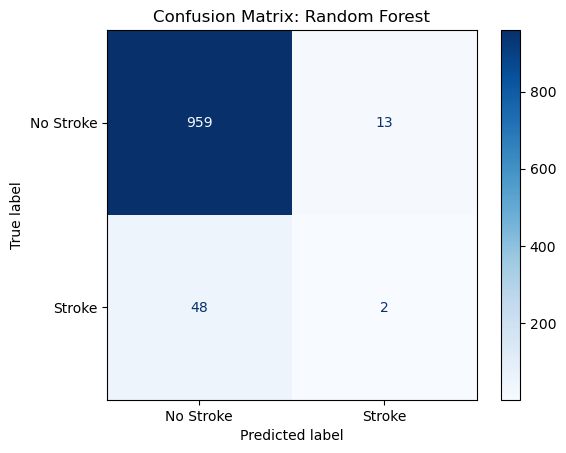


Logistic Regression Results:
AUC: 0.8456, F1: 0.3222, Accuracy: 0.8806, Precision: 0.2231, Recall: 0.5800


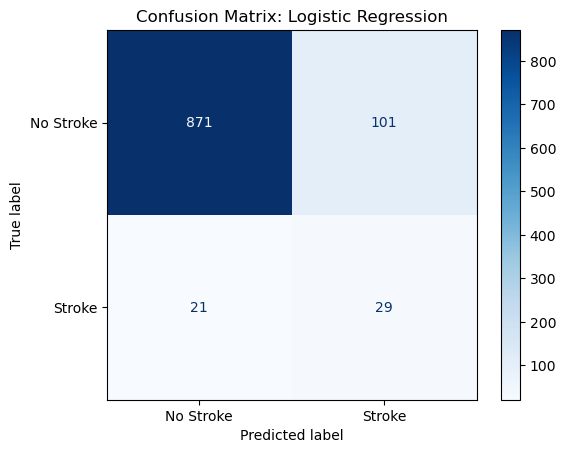


Decision Tree Results:
AUC: 0.5584, F1: 0.1600, Accuracy: 0.9178, Precision: 0.1600, Recall: 0.1600


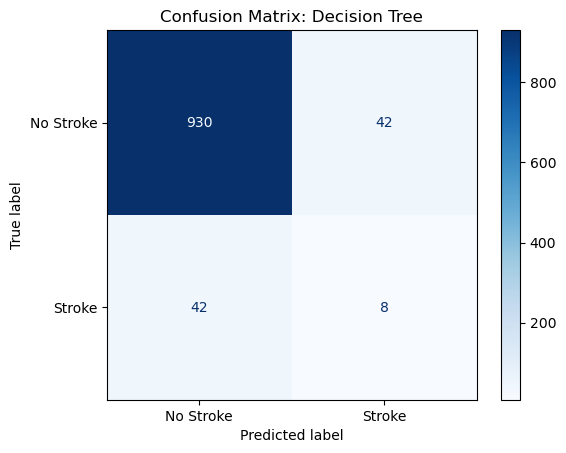

32/32 [==============================] - 0s 1ms/step

Deep Learning Results:
AUC: 0.7749, F1: 0.1636, Accuracy: 0.9100, Precision: 0.1500, Recall: 0.1800


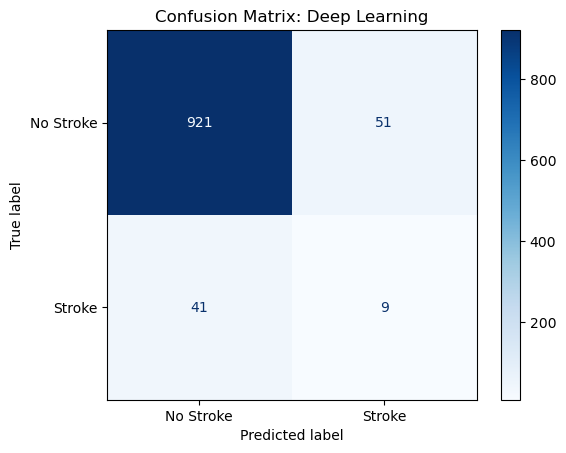


Model Performance Summary:


,Model,AUC,F1,Accuracy,Precision,Recall
0,Random Forest,0.735720,0.061538,0.940313,0.133333,0.04
1,Logistic Regression,0.845597,0.322222,0.880626,0.223077,0.58
2,Decision Tree,0.558395,0.160000,0.917808,0.160000,0.16
3,Deep Learning,0.774856,0.163636,0.909980,0.150000,0.18


In [26]:
#Define class weights for imbalanced classes
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(class_weight={0: 1, 1: 5}, classes=np.unique(y_train_res), y=y_train_res)
class_w = dict(zip(np.unique(y_train_res), weights))
print("Class Weights:", class_w)

results_df = pd.DataFrame(columns=['Model', 'AUC', 'F1', 'Accuracy', 'Precision', 'Recall'])

# Train and Evaluate Random Forest
rf_model = RandomForestClassifier(random_state=42, class_weight=class_w)
rf_model.fit(X_train_res, y_train_res)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
y_pred_rf = rf_model.predict(X_test)

auc_rf = roc_auc_score(y_test, y_proba_rf)
f1_rf = f1_score(y_test, y_pred_rf, zero_division=0)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, zero_division=0)
recall_rf = recall_score(y_test, y_pred_rf, zero_division=0)

results_df.loc[len(results_df)] = ['Random Forest', auc_rf, f1_rf, accuracy_rf, precision_rf, recall_rf]

print("Random Forest Results:")
print(f"AUC: {auc_rf:.4f}, F1: {f1_rf:.4f}, Accuracy: {accuracy_rf:.4f}, Precision: {precision_rf:.4f}, Recall: {recall_rf:.4f}")

cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["No Stroke", "Stroke"])
disp_rf.plot(cmap="Blues")
plt.title("Confusion Matrix: Random Forest")
plt.show()

# Train and Evaluate Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight=class_w)
lr_model.fit(X_train_res, y_train_res)
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]
y_pred_lr = lr_model.predict(X_test)

auc_lr = roc_auc_score(y_test, y_proba_lr)
f1_lr = f1_score(y_test, y_pred_lr, zero_division=0)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, zero_division=0)
recall_lr = recall_score(y_test, y_pred_lr, zero_division=0)

results_df.loc[len(results_df)] = ['Logistic Regression', auc_lr, f1_lr, accuracy_lr, precision_lr, recall_lr]

print("\nLogistic Regression Results:")
print(f"AUC: {auc_lr:.4f}, F1: {f1_lr:.4f}, Accuracy: {accuracy_lr:.4f}, Precision: {precision_lr:.4f}, Recall: {recall_lr:.4f}")

cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["No Stroke", "Stroke"])
disp_lr.plot(cmap="Blues")
plt.title("Confusion Matrix: Logistic Regression")
plt.show()


# Train and Evaluate Decision Tree
dt_model = DecisionTreeClassifier(random_state=42, class_weight=class_w)
dt_model.fit(X_train_res, y_train_res)
y_proba_dt = dt_model.predict_proba(X_test)[:, 1]
y_pred_dt = dt_model.predict(X_test)

auc_dt = roc_auc_score(y_test, y_proba_dt)
f1_dt = f1_score(y_test, y_pred_dt, zero_division=0)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt, zero_division=0)
recall_dt = recall_score(y_test, y_pred_dt, zero_division=0)

results_df.loc[len(results_df)] = ['Decision Tree', auc_dt, f1_dt, accuracy_dt, precision_dt, recall_dt]

print("\nDecision Tree Results:")
print(f"AUC: {auc_dt:.4f}, F1: {f1_dt:.4f}, Accuracy: {accuracy_dt:.4f}, Precision: {precision_dt:.4f}, Recall: {recall_dt:.4f}")

cm_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=["No Stroke", "Stroke"])
disp_dt.plot(cmap="Blues")
plt.title("Confusion Matrix: Decision Tree")
plt.show()


# Train and Evaluate Deep Learning Model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

dl_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

dl_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

dl_model.fit(X_train_scaled, y_train_res, epochs=50, batch_size=32, verbose=0, class_weight=class_w)
y_proba_dl = dl_model.predict(X_test_scaled).flatten()

# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
y_pred_dl = (y_proba_dl > 0.5).astype(int)

auc_dl = roc_auc_score(y_test, y_proba_dl)
f1_dl = f1_score(y_test, y_pred_dl, zero_division=0)
accuracy_dl = accuracy_score(y_test, y_pred_dl)
precision_dl = precision_score(y_test, y_pred_dl, zero_division=0)
recall_dl = recall_score(y_test, y_pred_dl, zero_division=0)

results_df.loc[len(results_df)] = ['Deep Learning', auc_dl, f1_dl, accuracy_dl, precision_dl, recall_dl]

print("\nDeep Learning Results:")
print(f"AUC: {auc_dl:.4f}, F1: {f1_dl:.4f}, Accuracy: {accuracy_dl:.4f}, Precision: {precision_dl:.4f}, Recall: {recall_dl:.4f}")

cm_dl = confusion_matrix(y_test, y_pred_dl)
disp_dl = ConfusionMatrixDisplay(confusion_matrix=cm_dl, display_labels=["No Stroke", "Stroke"])
disp_dl.plot(cmap="Blues")
plt.title("Confusion Matrix: Deep Learning")
plt.show()

# Summarize Results
print("\nModel Performance Summary:")
display(results_df)